In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as ss
import scipy.optimize as so
import tqdm

In [2]:
mpl.rcParams['figure.dpi'] *= 2

In [3]:
rng = np.random.default_rng()

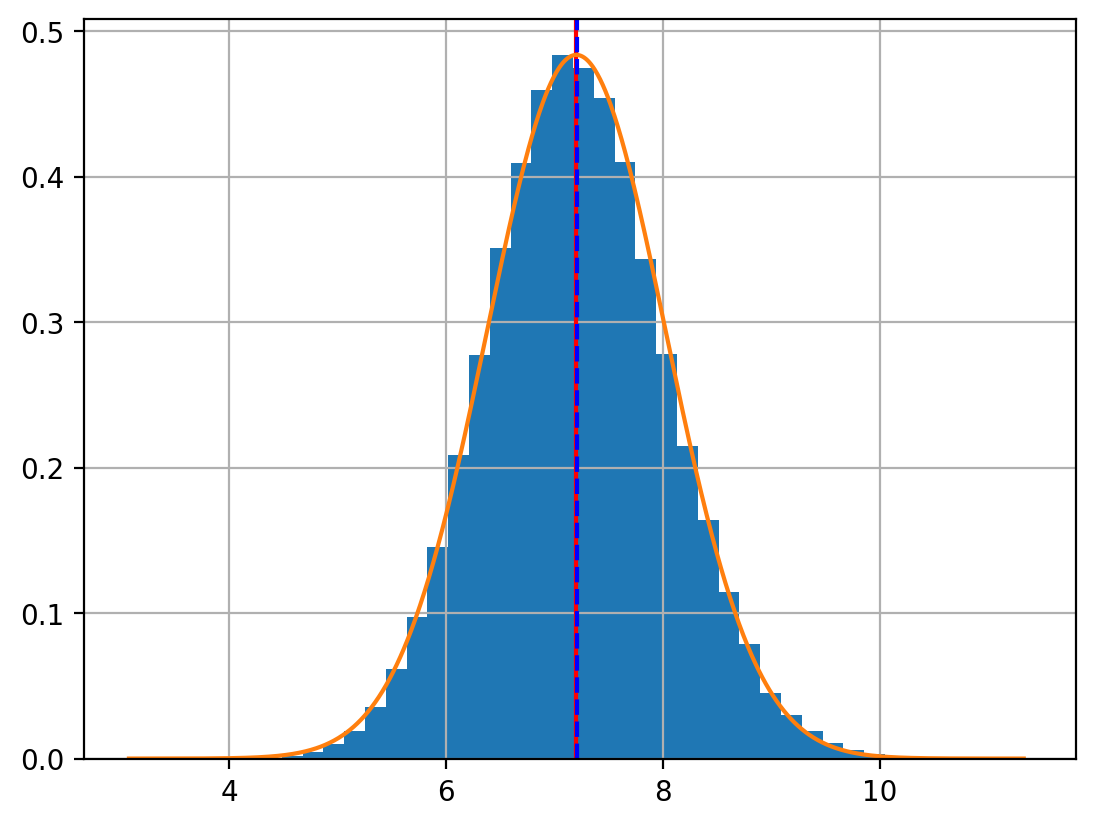

In [4]:

# means
R0 = 160/100 # TES resistance (mOhm)
b0 = 2.5 # beta

# std devs
dR = R0/10
db = b0/10

# typical ranges
Rm_space = dR*np.linspace(-5, 5, 1000) + R0
bm_space = db*np.linspace(-5, 5, 1000) + b0

def R(N = 100):
    return rng.normal(loc = R0, scale = dR, size = N)

def b(N = 100):
    return rng.normal(loc = b0, scale = db, size = N)

def normal(x, mu, sig):
    return np.exp(-(x-mu)**2/2/sig**2)/np.sqrt(2*np.pi)/sig

def Rnormal(x):
    return normal(x, R0, dR)
def bnormal(x):
    return normal(x, b0, db)


N = 100_000
Rbs = R(N)*(2+b(N))

# combined params
Rb0 = R0*(2 + b0)
dRb = np.sqrt(dR**2*db**2 + dR**2*(2+b0)**2 + db**2*R0**2)

xs = dRb*np.linspace(-5, 5, 1000) + Rb0

Rb_dist= normal(xs, Rb0, dRb)

plt.figure()
plt.grid()
plt.hist(Rbs, density = True, bins = 40)
plt.axvline(Rb0, color = 'r')
plt.axvline(Rbs.mean(), color = 'b', linestyle = '--')
plt.plot(xs, Rb_dist)

In [5]:

def show_approx(R0 = 2.5, b0 = 0.5, rel_dR = 0.1, rel_db = 0.1):
    # means
    #R0 = TES resistance (mOhm)
    #b0 = beta


    dR = R0*rel_dR
    db = b0*rel_db

    # typical ranges
    #Rm_space = dR*np.linspace(-5, 5, 1000) + R0
    #bm_space = db*np.linspace(-5, 5, 1000) + b0

    def R(N = 100):
        return rng.normal(loc = R0, scale = dR, size = N)

    def b(N = 100):
        return rng.normal(loc = b0, scale = db, size = N)

    N = 1000_000
    Rbs = R(N)*(2+b(N))

    # combined params
    Rb0 = R0*(2 + b0)
    dRb = np.sqrt(dR**2*db**2 + dR**2*(2+b0)**2 + db**2*R0**2)

    xs = dRb*np.linspace(-5, 5, 1000) + Rb0

    Rb_dist= normal(xs, Rb0, dRb)

    plt.figure()
    plt.title(f'$\\beta = {b0}$, $\\Delta\\beta/\\beta = ${rel_db*100:.0f}%')
    plt.grid()
    plt.hist(Rbs, density = True, bins = 100, label = f'simulation\n({N:.0g} samples)')
    plt.axvline(Rb0, color = 'r', label = 'predicted mean')
    plt.axvline(Rbs.mean(), color = 'b', linestyle = '--', label = 'sample mean')
    plt.plot(xs, Rb_dist, label = 'gaussian approx')
    plt.legend()
    plt.xlabel('$R_m(2+\\beta_m)$')

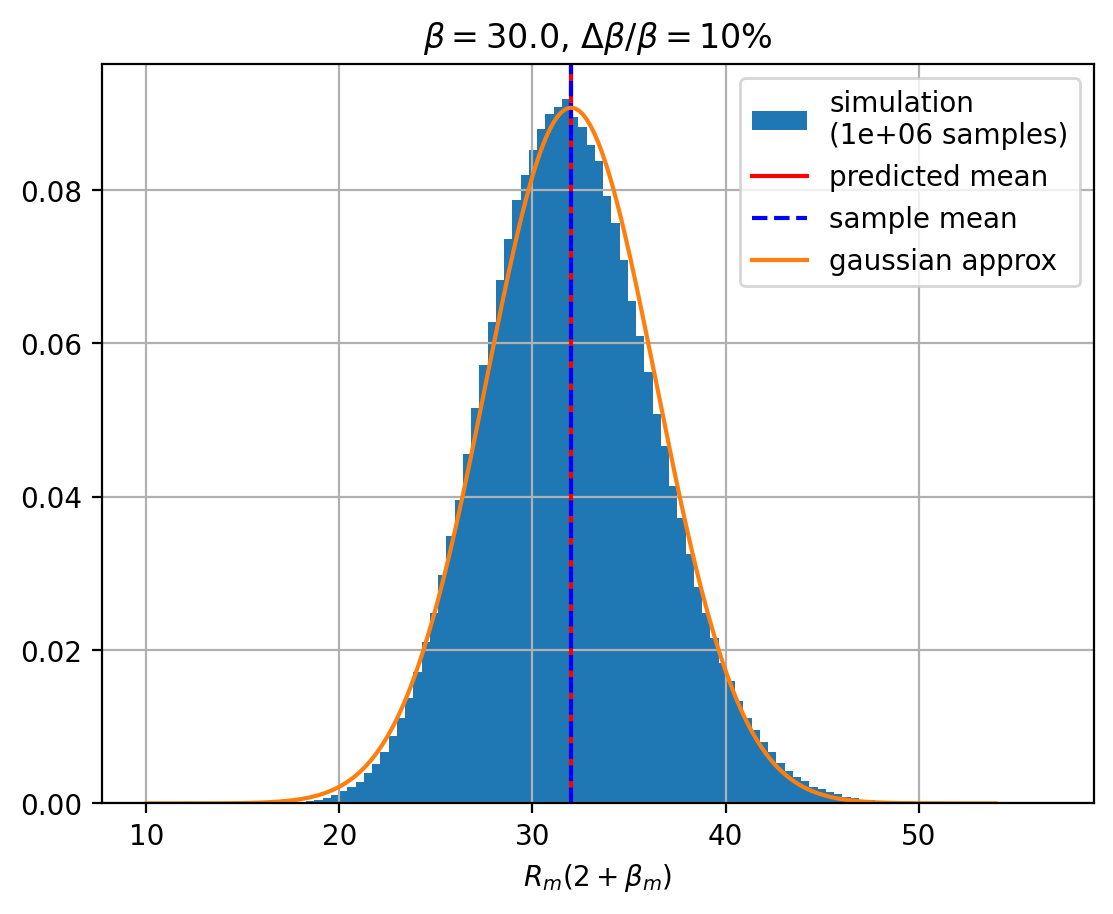

In [6]:
show_approx(R0 = 1, b0 = 30., rel_db = 0.1)

In [7]:

def show_dist(R0 = 2.5, b0 = 0.5, rel_dR = 0.1, rel_db = 0.1, M = 100, dv = 0.01):
    # means
    #R0 = TES resistance (mOhm)
    #b0 = beta

    vm = rng.normal(loc = 1, scale = dv, size = (M,1))
    #vm = 2*rng.random(size = (M,1))

    #vm = rng.choice((-1,1), size = (M,1))*rng.normal(loc = dv, scale = 0.1*dv, size = (M,1))

    #vm /= vm.mean()


    dR = R0*rel_dR
    db = b0*rel_db

    # typical ranges
    #Rm_space = dR*np.linspace(-5, 5, 1000) + R0
    #bm_space = db*np.linspace(-5, 5, 1000) + b0

    def R(N = 100):
        return rng.normal(loc = R0, scale = dR, size = (M,N))

    def b(N = 100):
        return rng.normal(loc = b0, scale = db, size = (M,N))

    N = 1000_000
    Rbs = (vm*R(N)*(2+b(N))).sum(axis = 0)/vm.sum()

    # combined params
    Rb0 = R0*(2 + b0)
    D2 = dR**2*db**2 + dR**2*(2+b0)**2 + db**2*R0**2

    var = (1 + dv**2)*D2/M

    xs = np.sqrt(var)*np.linspace(-5, 5, 1000) + Rb0

    Rb_dist = normal(xs, Rb0, np.sqrt(var))
    Rb_dist2 = normal(xs, Rb0, np.sqrt(D2/M))

    plt.figure()
    plt.title(f'$\\beta = {b0}$, $\\Delta\\beta/\\beta = ${rel_db*100:.0f}%, $\\delta v = ${dv*100:.0f}%')
    plt.grid()
    plt.hist(Rbs, density = True, bins = 100, label = f'simulation\n({N:.0g} samples)')
    plt.axvline(Rb0, color = 'r', label = 'predicted mean')
    plt.axvline(Rbs.mean(), color = 'b', linestyle = '--', label = 'sample mean')
    plt.plot(xs, Rb_dist, label = 'gaussian approx')
    plt.plot(xs, Rb_dist2, label = 'approx w/ zero dv')
    plt.legend()
    plt.xlabel('$\sum_mv_mR_m(2+\\beta_m)/\\sum_mv_m$')

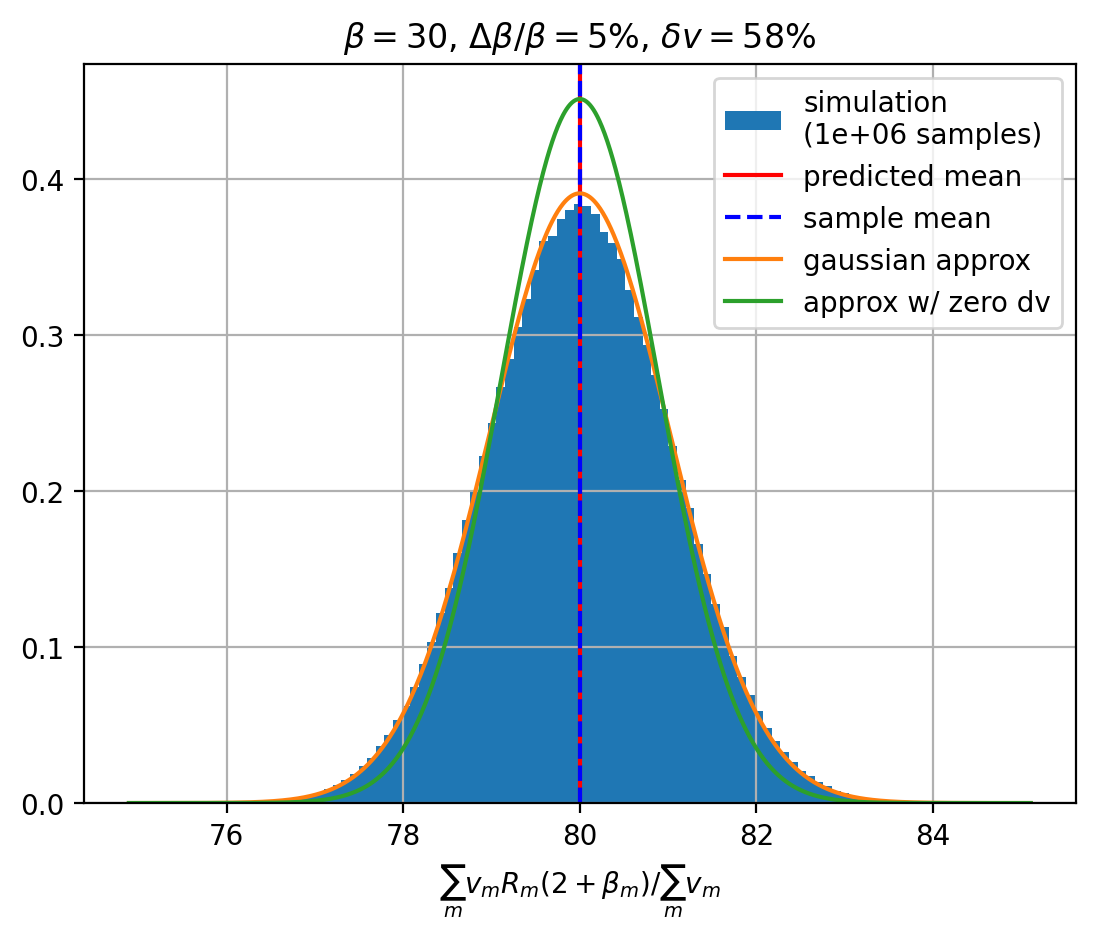

In [8]:
show_dist(b0 = 30, rel_db = 0.05, dv = np.sqrt(1/3))

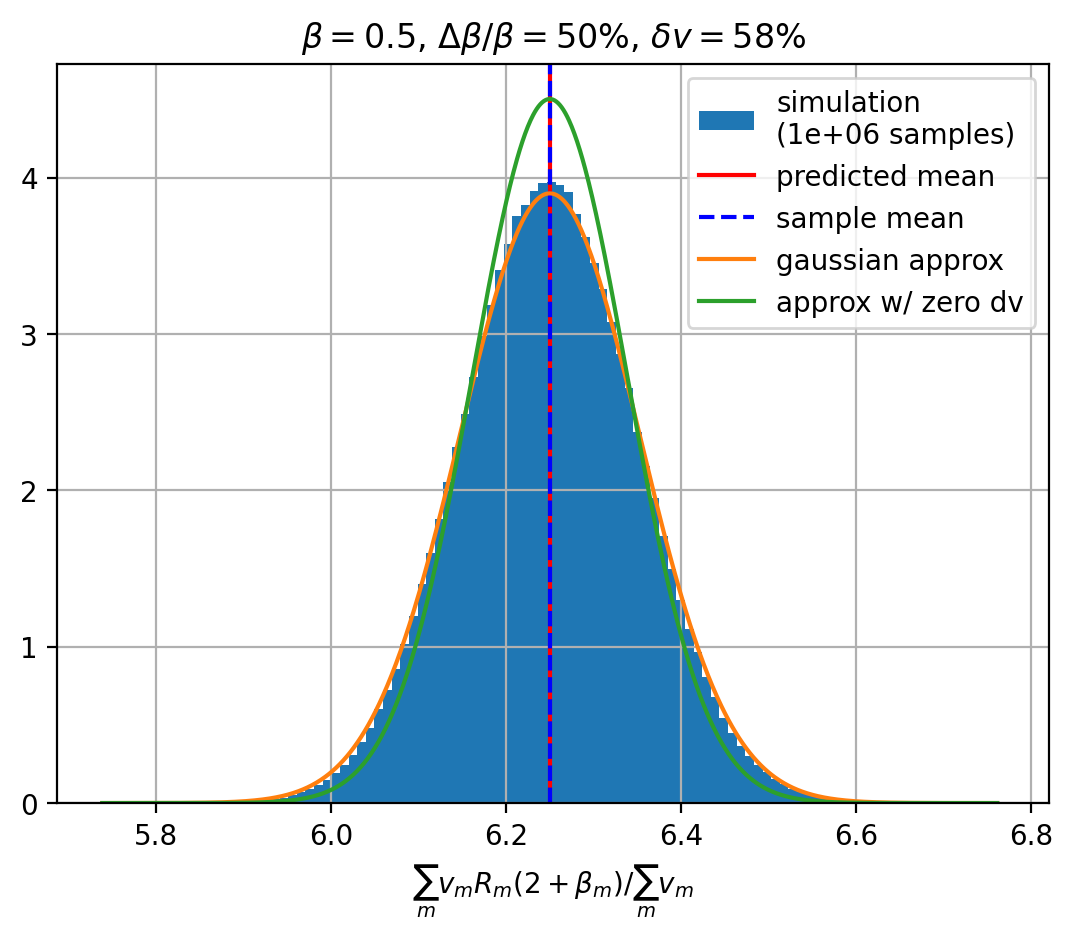

In [9]:
show_dist(b0 = 0.5, rel_db = 0.5, dv = np.sqrt(1/3))# 0.5

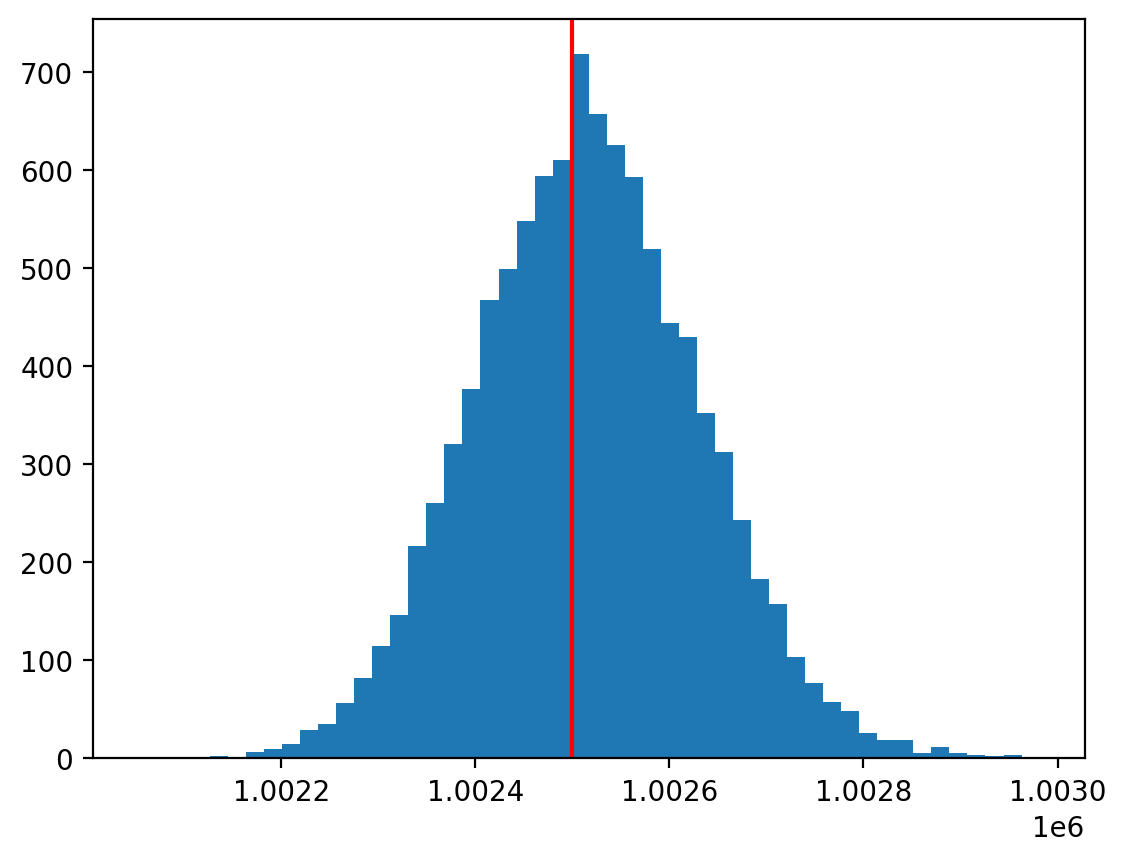

In [10]:
def get_thing(M = 10_000, dv = 0.01):

    #vm = rng.choice((-1,1), size = M)*rng.random(size = M)
    #vm = rng.choice((-1,1), size = M)*(rng.standard_normal(size = M)+1)
    vm = rng.normal(loc = 1, scale = dv, size = M)
    #vm = rng.random(size = M)

    return (1/vm).sum(axis = 0)*vm.sum(axis = 0)


M = 1000
trials = 10_000
dv = 0.05

plt.hist(get_thing((M, trials), dv = dv), bins = 50)
#plt.loglog()
plt.axvline(M**2*(1 + dv**2), color = 'r')

In [11]:
get_thing((M, trials), dv = dv).size # should be 10_000 (= trials)

10000

In [12]:
def complex_histogram(data, bins = 40, **kwargs):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, **kwargs)

    axs[0].hist(np.real(data), bins = bins)
    axs[1].hist(np.imag(data), bins = bins)
    axs[0].set_title('Re(z)')
    axs[1].set_title('Im(z)')

    return fig, axs

random matrix

In [13]:


class ElectrothermalSystem:

    def __init__(self, M, N, syst_params):

        self.M = M
        self.N = N
        self.syst_params = syst_params

        self.rng = np.random.default_rng()

        self.set_system_params(**self.syst_params)
        self.generate_everything()



    def set_system_params(self, I0, L, Rl, Rtot, Rdev, Tmean, Tdev, Ctot, Cdev, gmean, gdev, Bmean, Bdev, Amean, Adev):
        self.I0 = I0
        self.L = L
        self.Rl = Rl
        self.Rmean = Rtot/self.M
        self.Rdev = Rdev
        self.Tmean = Tmean
        self.Tdev = Tdev
        self.Cmean = Ctot/(self.M+self.N)
        self.Cdev = Cdev
        self.gmean = gmean/self.M
        self.gdev = gdev
        self.Bmean = Bmean
        self.Bdev = Bdev
        self.Amean = Amean
        self.Adev = Adev

    def generate_everything(self):
        M = self.M
        N = self.N

        self.base_coefficient_mtx = np.zeros((M+N+1,M+N+1), dtype = np.cdouble)

        # component resistances
        self.R_m = rng.normal(loc = self.Rmean, scale = self.Rmean*self.Rdev, size = M) 

        # component heat capacities
        self.C_i = self.rng.normal(loc = self.Cmean, scale = self.Cmean*self.Cdev, size = (M+N)) 

        # component equilibrium temperatures
        self.T_i = self.rng.normal(loc = self.Tmean, scale = self.Tmean*self.Tdev, size = (M+N))

        # mask for external connections -- immediate nearest neighbors + (N/M) external heat capacities per TES component
        i, j = np.meshgrid(np.arange(M+N), np.arange(M+N))
        NEAREST_NEIGHBOR = abs(i - j) < 2
        OUTER_CONNECTIONS = (i<M)*(j>=M)*((j-M)//(N//M) == i) + (j<M)*(i>=M)*((i-M)//(N//M) == j)

        self.g_ij = self.rng.normal(loc = self.gmean, scale = self.gmean*self.gdev, size = (M+N,M+N))#*(NEAREST_NEIGHBOR+OUTER_CONNECTIONS) # conductance matrix
        #self.g_ij *= self.rng.random((self.g_ij.shape)) > 0.9 # mask most elements

        self.beta_m = self.rng.normal(loc = self.Bmean, scale = self.Bmean*self.Bdev, size = M)
        self.alpha_m = self.rng.normal(loc = self.Amean, scale = self.Amean*self.Adev, size = M)

        self.G_i = self.g_ij.sum(axis = 1)

        self.Ell_m = (self.I0**2)*self.R_m*self.alpha_m/self.G_i[:M]/self.T_i[:M]

        self.tau_m = self.C_i[:M]/self.G_i[:M]/(1-self.Ell_m)

        self.Rbeta = self.R_m*(2+self.beta_m)

        
        self.base_coefficient_mtx[0,1:M+1] = self.G_i[:M]*self.Ell_m/self.I0/self.L
        self.base_coefficient_mtx[1:M+1,0] = -self.I0*self.Rbeta/self.C_i[:M]
        self.base_coefficient_mtx[1:,1:] = -self.g_ij/self.C_i[:,np.newaxis]

        diagonal = np.zeros(1+M+N, dtype = np.cdouble)
        diagonal[0] = (self.Rl * self.Rbeta.sum())/self.L
        diagonal[1:M+1] = self.G_i[:M]*(1-self.Ell_m)/self.C_i[:M]
        diagonal[-N:] = self.G_i[-N:]/self.C_i[-N:]
        np.fill_diagonal(self.base_coefficient_mtx, diagonal)


    def get_M(self, w):
        return 1j*w*np.identity((self.M+self.N+1), dtype = np.cdouble) + self.base_coefficient_mtx

    def get_logDm(self, w):

        M = self.M
        N = self.N

        MM = self.get_M(w)
        Dm = []

        for m in range(M+1):
            sub_M = np.zeros((M+N,M+N), dtype = np.cdouble)
            sub_M[:m,:] = MM[:m,1:]
            sub_M[m:,:] = MM[m+1:,1:]
            #sub_M[m:,:m] = MM[m+1:,:m]
            #sub_M[m:,m:] = MM[m+1:,m+1:]
            Dm.append(np.linalg.slogdet(sub_M))

        phase, logDm = np.array(Dm).T
        
        alt = (-1)**np.arange(M+1) # alternating sign (starting -1, +1, -1...)

        return alt*phase, logDm

    def get_R_avg(self, w, regen = False):

        M = self.M

        if regen:
            self.generate_everything()

        phase, logDm = self.get_logDm(w)
        lD0 = logDm[0]

        #for m in range(M):
        #    for n in range(M):
        #        total += (-1)**(n+m)*(self.C_i[n]/self.C_i[m])*(phase[m+1]/phase[n+1])*np.exp(logDm[m+1]-logDm[n+1])*(self.R_m[m]*(2+self.beta_m[m]))


        total = (self.C_i[:M]/phase[1:]/np.exp(logDm[1:]-lD0)).sum()*(phase[1:]*np.exp(logDm[1:]-lD0)*self.Rbeta/self.C_i[:M]).sum()

        return total


# end ElectrothermalSystem class

syst_params = {
    'I0': 80e-6, # equilibrium bias current (A)
    'L': 250e-9, # inductance (H)
    'Rtot': 160e-3, # total channel resistance R_{m,0} (Ohm)
    'Rdev': 0.01, # relative deviation in R_{m,0} about Rmean = Rtot/M
    'Ctot': 1e-5, # total component heat capacity C_m (J/K) (TES and external)
    'Cdev': 0.01, # relative deviation in C_m about Cmean = Ctot/(M+N)
    'gmean': 1e-9, # mean thermal conductance g_{ij} (J/K)
    'gdev': 0.01, # relative deviation in g_{ij}
    'Bmean': 1, # mean beta_m (current responsivity)
    'Bdev': 0.01, # relative deviation in beta_m
    'Amean': 200, # mean alpha_m (thermal responsivity)
    'Adev': 0.01, # relative deviation in alpha_m
    'Tmean': 0.05, # mean operating temperature (K)
    'Tdev': 0.01, # relative deviation in Tmean
    'Rl': 5e-3, # parasitic resistance
}



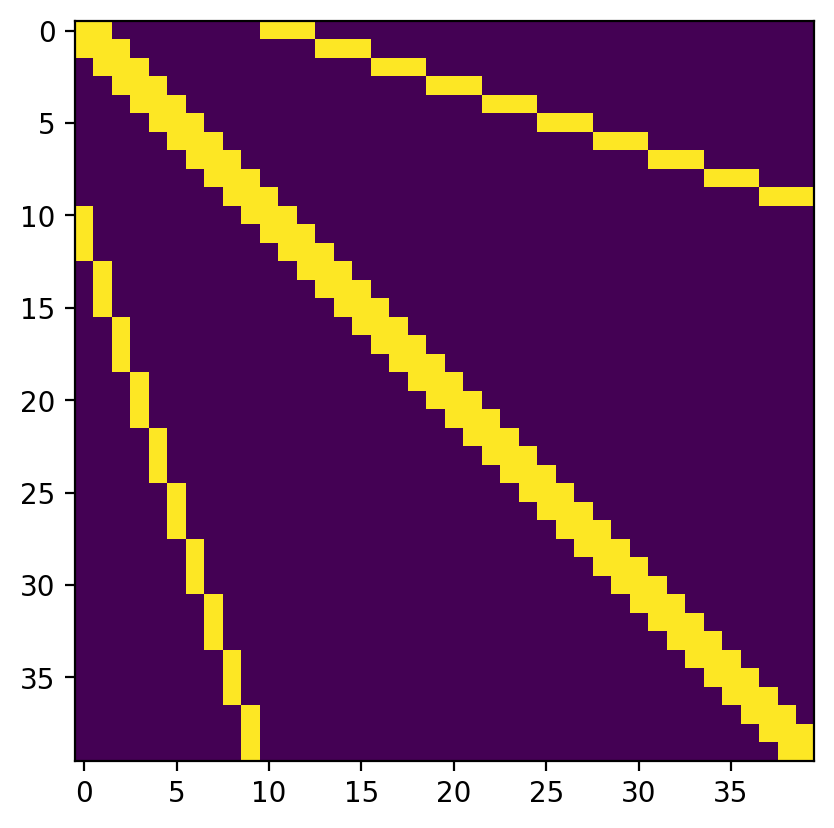

In [14]:
# nearest neighbor and distributed outer connections to TES components
M = 10
N = 30
i, j = np.meshgrid(np.arange(M+N), np.arange(M+N))
NEAREST_NEIGHBOR = (abs(i - j) < 2)
OUTER_CONNECTIONS = (i<M)*(j>=M)*((j-M)//(N//M) == i) + (j<M)*(i>=M)*((i-M)//(N//M) == j)
#plt.imshow(NEAREST_NEIGHBOR)
#plt.imshow(OUTER_CONNECTIONS)
plt.imshow((OUTER_CONNECTIONS+NEAREST_NEIGHBOR))

In [15]:
# distribution of R_avg/Rmean (real and imag) at 10 kHz for M = 300, N = 900
numrepeats = 200
M1 = 20
N1 = 40
R_avg = np.zeros(numrepeats, dtype = np.cdouble)
etm2 = ElectrothermalSystem(M1, N1, syst_params)

for i in tqdm.trange(numrepeats):
    R_avg[i] = etm2.get_R_avg(1e4/2/np.pi, regen = True)

100%|██████████| 200/200 [00:00<00:00, 979.47it/s]


In [16]:
z, logDm = etm2.get_logDm(1e4/2/np.pi)
k = logDm.mean()
w = z*np.exp(logDm - k)
Dm_var = (((w - w.mean())**2).mean())/w.mean()**2
Dm_var

(0.04885785667803489+0.016239482353301145j)

In [17]:
w.mean()

(-0.006624870993881188+1.0410145625551672j)

In [18]:
np.sqrt(((w - w.mean())**2).mean())/w.mean()

(-0.22399094109693765-0.03625031055669591j)

In [19]:
(w.std()/abs(w.mean()))**2 + syst_params['Rdev']**2 + syst_params['Bdev']**2

0.05170097915036297

In [20]:
somevar = 0
for key, val in syst_params.items():
    if 'dev' in key:
        print(key, ':', val)
        somevar += val**2

Rdev : 0.01
Cdev : 0.01
gdev : 0.01
Bdev : 0.01
Adev : 0.01
Tdev : 0.01


In [ ]:
syst_params['Bmean']

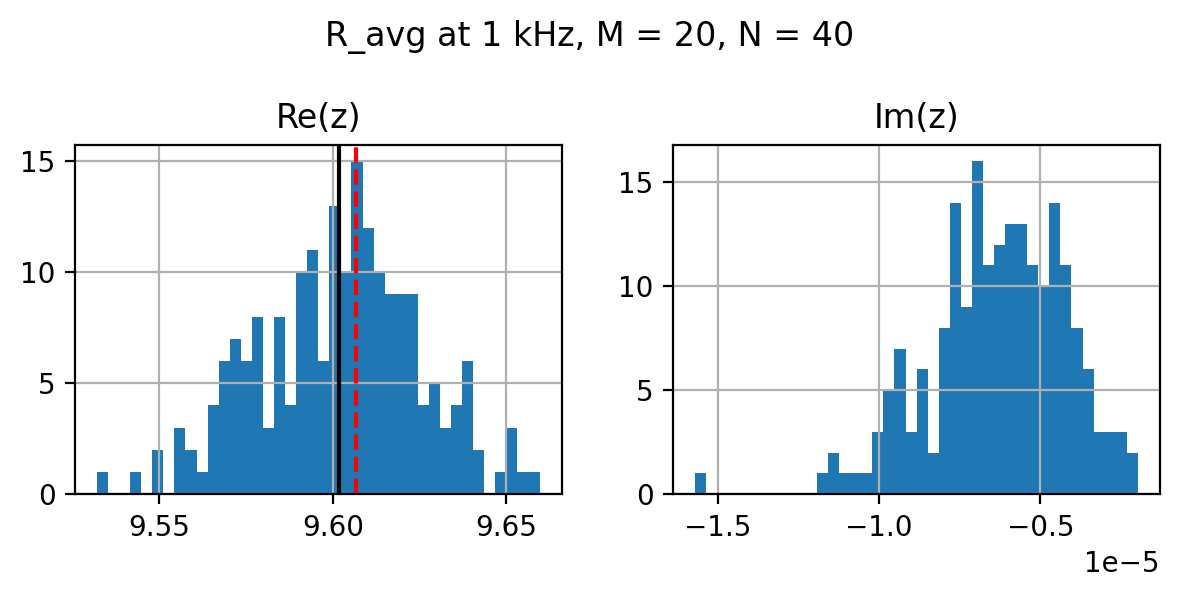

In [21]:

fig, axs = complex_histogram(R_avg, figsize = (6,3))
fig.suptitle(f'R_avg at 1 kHz, M = {etm2.M}, N = {etm2.N}')
for ax in axs:
    ax.grid()
axs[0].axvline(np.real(R_avg).mean(), color = 'k')
axs[0].axvline((M1**2)*(1 + somevar + 0*(w.std()/abs(w.mean()))**2 + 0*np.real(Dm_var) + syst_params['Cdev']**2)*etm2.Rmean*(2+etm2.Bmean), color = 'r', linestyle = 'dashed')
#axs[1].axvline((M1**2)*(np.imag(Dm_var))*etm2.Rmean*(2+etm2.Bmean), color = 'r', linestyle = 'dashed')
fig.tight_layout()

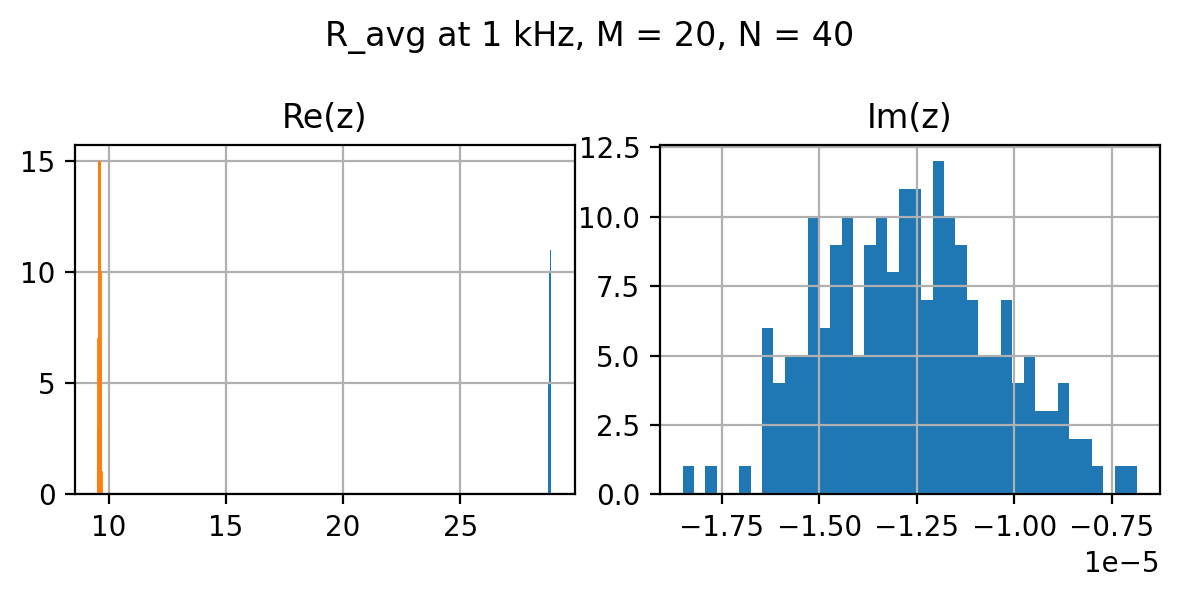

In [22]:
#np.savetxt('Ravg_300_900_1kHz.dat', R_avg)
R_avg2 = np.loadtxt('Ravg_300_900_1kHz.dat', dtype = np.cdouble)
fig, axs = complex_histogram(R_avg2, figsize = (6,3))
axs[0].hist(np.real(R_avg), histtype = 'step', bins = 40)
fig.suptitle(f'R_avg at 1 kHz, M = {etm2.M}, N = {etm2.N}')
for ax in axs:
    ax.grid()
#axs[0].axvline((1 + 0)*etm2.Rmean*(2+etm2.Bmean), color = 'r', linestyle = 'dashed')
fig.tight_layout()

In [23]:
small_syst = ElectrothermalSystem(2,3, syst_params)

np.real(small_syst.base_coefficient_mtx)

array([[ 9.61406309e+03,  1.02858733e+05,  1.01286615e+05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.62808381e+00, -1.02503169e+00, -2.47832691e-04,
        -2.48570773e-04, -2.49096878e-04, -2.46652903e-04],
       [-9.42532501e+00, -2.43583346e-04, -9.95459643e-01,
        -2.45934474e-04, -2.44021556e-04, -2.46341018e-04],
       [ 0.00000000e+00, -2.46941374e-04, -2.50694552e-04,
         1.25459487e-03, -2.54519660e-04, -2.50911424e-04],
       [ 0.00000000e+00, -2.54279390e-04, -2.47930756e-04,
        -2.49722660e-04,  1.25357490e-03, -2.46463468e-04],
       [ 0.00000000e+00, -2.54424833e-04, -2.53723153e-04,
        -2.55407212e-04, -2.53278939e-04,  1.26875518e-03]])

In [24]:

M = 300 # number of TES component heat capacities
N = 900 # number of external heat capacities


etm = ElectrothermalSystem(M, N, syst_params)

print(abs(etm.get_R_avg(1e3))/(etm.Rmean*(2+etm.Bmean)))

90079.69833260254


In [25]:
w = 1e3
MM = etm.get_M(w)
zm, logDms = etm.get_logDm(w)
z0, logD0 = np.linalg.slogdet(MM)

(MM[:M+1,0]*(zm/z0)*np.exp(logDms-logD0)).sum() # should be one

(0.9999999999811608-4.595573921406526e-12j)

In [26]:
k, z = small_syst.get_logDm(10)

In [28]:
vec, logDm = etm.get_logDm(1e1)
logD0 = logDm[0] # first entry (diagonal entry corresponding to M_{0,0})
Dm = (vec/vec[0])*np.exp(logDm - logD0)
Dmx = np.real(Dm[1:])
Dmy = np.imag(Dm[1:])

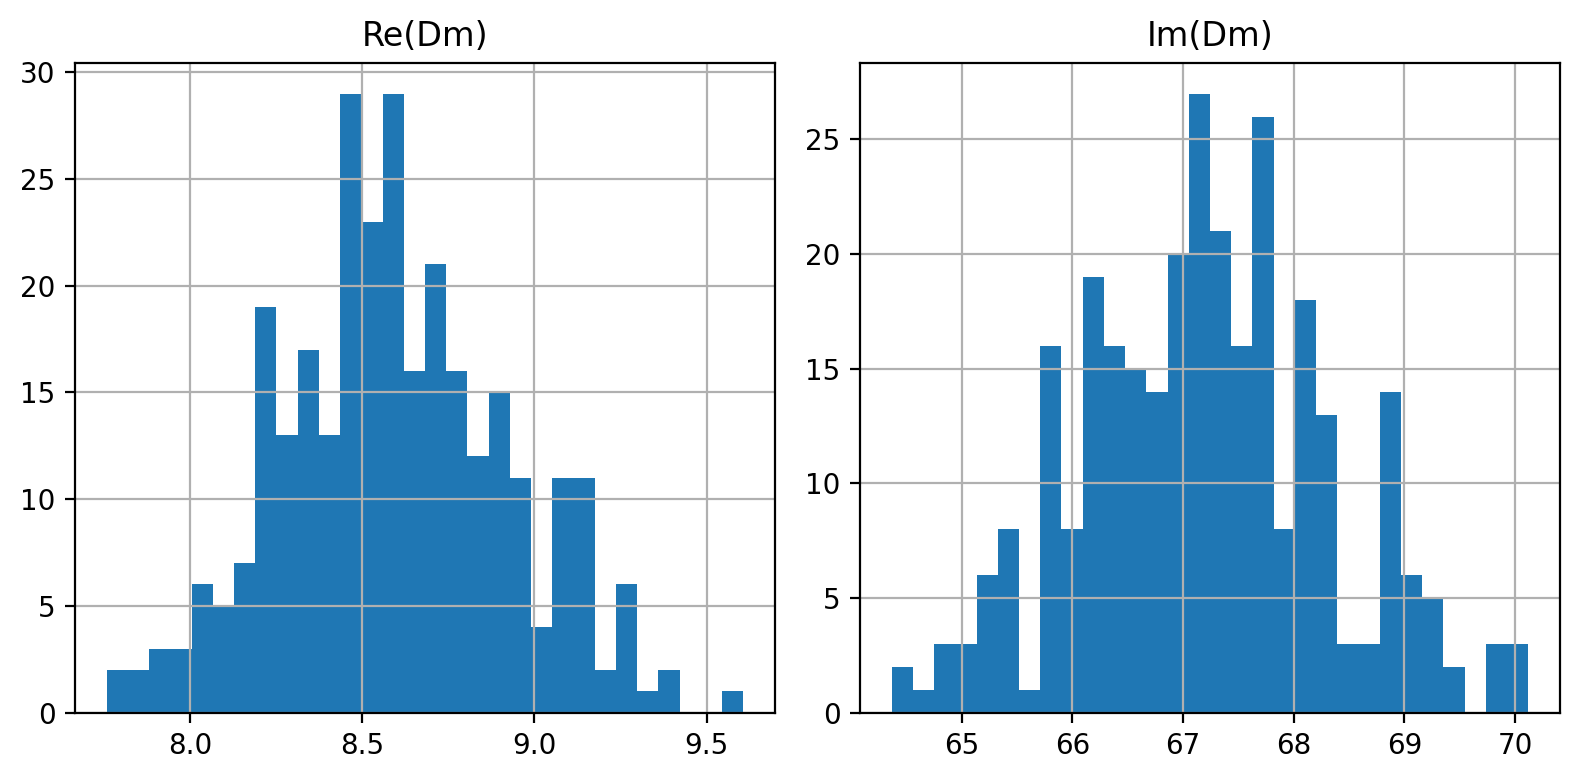

In [29]:

fig, axs  = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
axs[0].hist(Dmx, bins = 30)
axs[0].set_title('Re(Dm)')
axs[1].hist(Dmy, bins = 30)
axs[1].set_title('Im(Dm)')

for ax in axs:
    ax.grid()

fig.tight_layout()

In [30]:
vec[:4], logDm[:4]

(array([-0.6210751 -0.78375106j,  0.69570331-0.71832925j,
         0.69994205-0.71419964j,  0.69433414-0.71965277j]),
 array([2766.14458604+0.j, 2770.38541049+0.j, 2770.35340498+0.j,
        2770.39259208+0.j]))

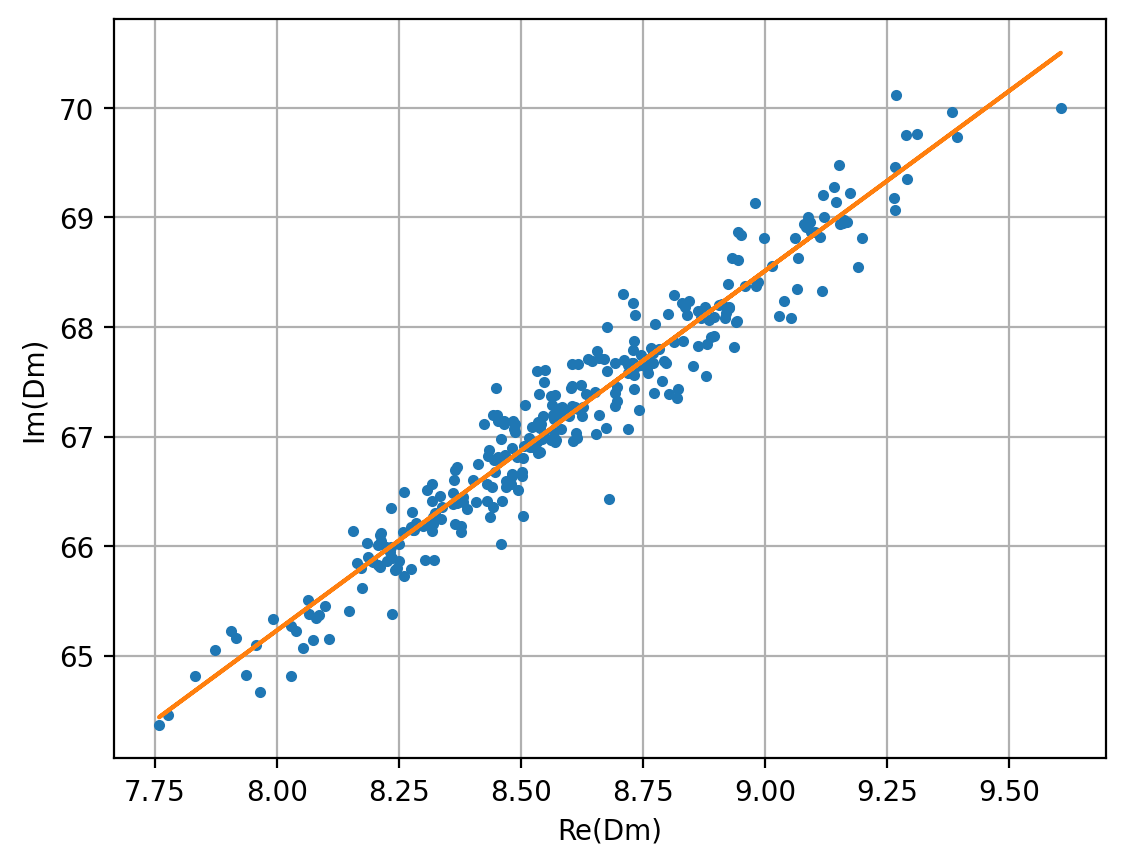

In [31]:
plt.figure()
plt.grid()
plt.xlabel('Re(Dm)')
plt.ylabel('Im(Dm)')
plt.plot(Dmx, Dmy, '.')
Dm_fit = ss.linregress(x = Dmx, y = Dmy)
Dml = Dmx*Dm_fit.slope + Dm_fit.intercept
plt.plot(Dmx, Dml)

In [32]:
Dm_fit

LinregressResult(slope=3.2826177979256683, intercept=38.96887725710724, rvalue=0.9703333115292148, pvalue=8.549952292609289e-186, stderr=0.04738006283322227, intercept_stderr=0.4075841200579021)

Text(0.5, 0, 'vertical residual from linear fit')

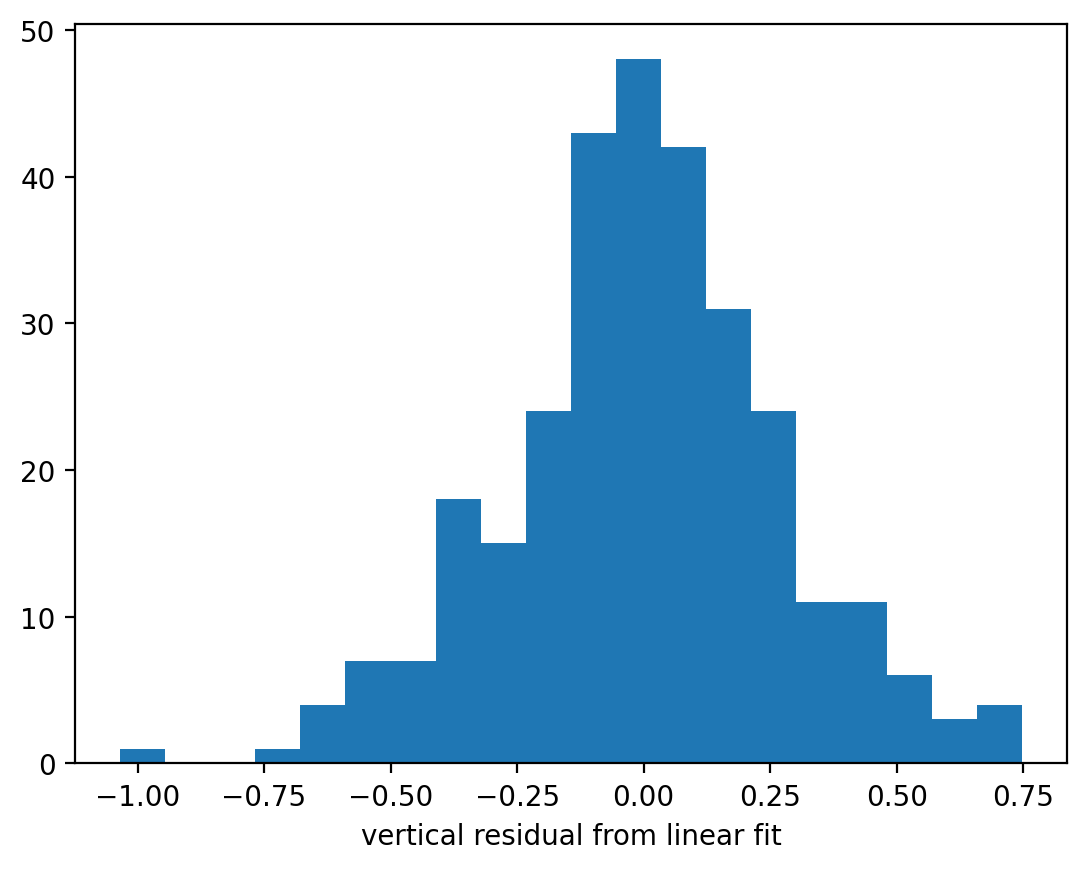

In [33]:
plt.hist(Dmy - Dml, bins = 20)
plt.xlabel('vertical residual from linear fit')

In [39]:
ws = np.geomspace(0.01, 1e6, 50)

ratios = np.array([abs(etm2.get_R_avg(w))/(etm.Rmean*(2+etm.Bmean)) for w in ws])

Text(0, 0.5, 'R_avg/Rmean')

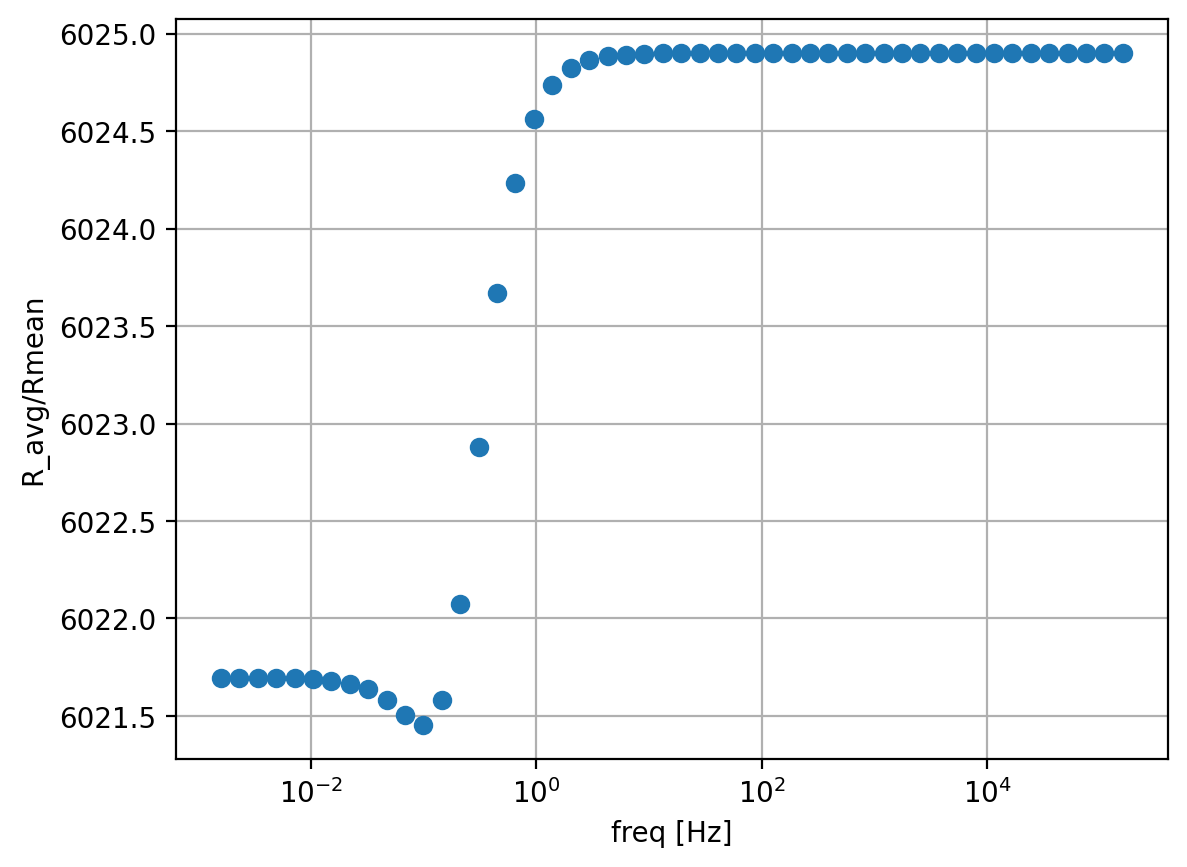

In [40]:
plt.figure()
plt.semilogx()
plt.plot(ws/2/np.pi, ratios, 'o')
plt.grid()
plt.xlabel('freq [Hz]')
plt.ylabel('R_avg/Rmean')